# Minimum, Maximum, and Mixture

In [1]:
include("utils.jl"); using .Utils
include("empiricaldist.jl"); using .EmpiricalDist

checkpkgs("Distributions", "Interpolations", "Plots", "StatsPlots", "DataFrames")

using Distributions, Plots, DataFrames

In [2]:
hypos = LinRange(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250;

In [3]:
"""Update pmf using the binomial distribution."""
function update_binomial!(pmf, data)
    k, n = data
    xs = pmf.qs
    likelihood = pdf.(Binomial.(n, xs), k)
    pmf .*= likelihood
    normalize!(pmf)
end

update_binomial!

In [4]:
update_binomial!(pmf, data);

In [5]:
cumulative = cumsum(pmf);

In [6]:
function decorate_euro!(title)
    xlabel!("Proportion of heads (x)")
    ylabel!("Probability")
    title!(title)
end
decorate_euro!(;title) = decorate_euro!(title)

decorate_euro! (generic function with 2 methods)

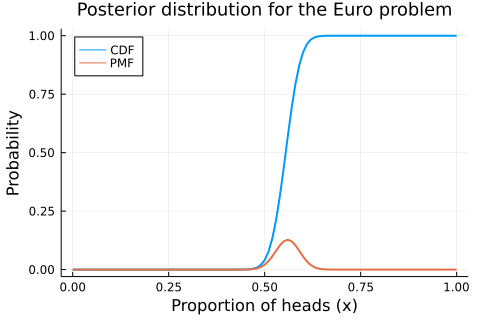

In [7]:
plot(cumulative, label="CDF")
plot!(pmf, label="PMF", titlefontsize=12, legend=:topleft)
decorate_euro!(title="Posterior distribution for the Euro problem")

In [8]:
cumulative[0.61]

0.9638303193984253

In [9]:
using Interpolations

ps = values(cumulative)
qs = keys(cumulative)

# NOTE: ps vector contains multiple repeating values -- i.e. the PMF there is 0 up to Float64 accuracy
# Interpolations doesn't like that and will complain.
#
# Interpolations.deduplicate_knots() can fix that
function prepare_for_interpolation(x, y)
    Interpolations.deduplicate_knots!(x)
    return x, y
end

ps, qs = prepare_for_interpolation(ps, qs)

interp = LinearInterpolation(ps, qs)
interp(0.96)

0.6089017054408619

In [10]:
cdf = makecdf(pmf);

In [11]:
cdf[0.61]

0.9638303193984255

In [12]:
try
    cdf[0.615]
catch e
    show(e)
end

KeyError(0.615)

In [13]:
cdf(0.615) # result is different from Python implementation as it depends on interpolation algorithm

0.9735854849783133

In [14]:
quantile(cdf, 0.9638303)

0.6099999944377523

In [15]:
credibleinterval(cdf, 0.9) # result depends on interpolation algorithm

2-element Vector{Float64}:
 0.5025940531880351
 0.6060343347469462

In [16]:
pmf = makepmf(cdf);

## Best Three of Four

In [17]:
# we'll just redefine make_die()
make_die(sides) = Pmf(1/sides, 1:sides)

die = make_die(6)
dice=repeat([die],3);

In [18]:
pmf_3d6 = adddist(dice);

In [19]:
function decorate_dice!(title="")
    plot!(xlabel="Outcome", ylabel="PMF", title=title, titlefontsize=10)
end
decorate_dice!(;title) = decorate_dice(title)

decorate_dice! (generic function with 2 methods)

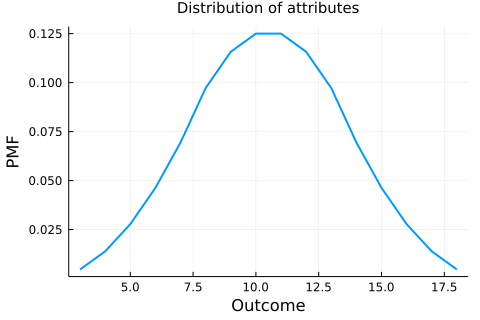

In [20]:
plot(pmf_3d6)
decorate_dice!("Distribution of attributes")

In [21]:
n = 10_000
a = rand(1:6, n, 4);

In [22]:
sort!(a, dims=2); # sort rows

In [23]:
t = sum(a[:, 2:end], dims=2);

In [24]:
pmf_best3 = pmffromseq(t);

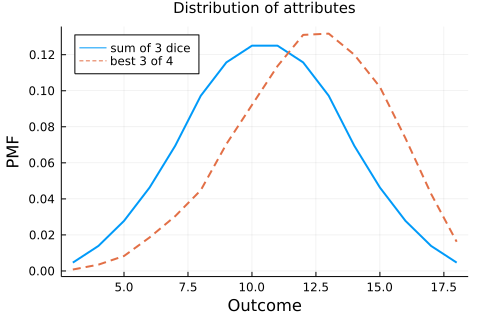

In [25]:
plot(pmf_3d6, label="sum of 3 dice")
plot!(pmf_best3, label="best 3 of 4", style=:dash, legend=:topleft)
decorate_dice!("Distribution of attributes")

## Maximum

In [26]:
cdf_best3 = makecdf(pmf_best3);

In [27]:
cdf_best3 .^ 6

┌────┬─────────────┐
│    │  cumulative │
├────┼─────────────┤
│  3 │ 2.62144e-19 │
│  4 │ 6.32136e-15 │
│  5 │  4.0015e-12 │
│  6 │ 9.22418e-10 │
│  7 │  5.46367e-8 │
│  8 │  1.45094e-6 │
│  9 │  3.05417e-5 │
│ 10 │ 0.000378046 │
│ 11 │  0.00313668 │
│ 12 │   0.0183548 │
│ 13 │   0.0722055 │
│ 14 │    0.200905 │
│ 15 │    0.425909 │
│ 16 │    0.694285 │
│ 17 │    0.906653 │
│ 18 │         1.0 │
└────┴─────────────┘


In [28]:
cdf_max6 = cdf_best3 .^ 6; # already a Cdf

In [29]:
pmf_max6 = makepmf(cdf_max6);

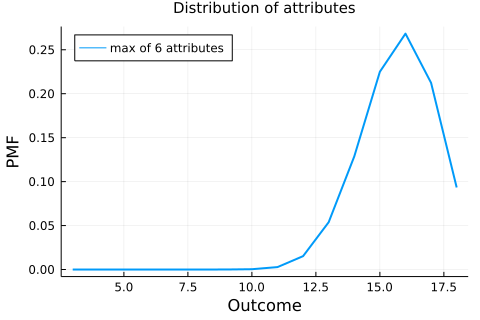

In [30]:
plot(pmf_max6, label="max of 6 attributes", legend=:topleft)
decorate_dice!("Distribution of attributes")

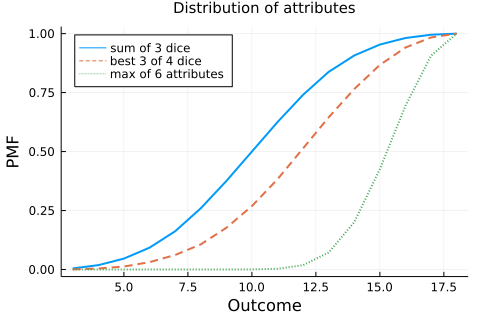

In [31]:
cdf_3d6 = makecdf(pmf_3d6)
plot(cdf_3d6, label="sum of 3 dice")

cdf_best3 = makecdf(pmf_best3)
plot!(cdf_best3, label="best 3 of 4 dice", style=:dash)

plot!(cdf_max6, label="max of 6 attributes", style=:dot, legend=:topleft)
ylabel!("CDF")
decorate_dice!("Distribution of attributes")

In [32]:
cdf_max_dist6 = maxdist(cdf_best3, 6);

In [33]:
isapprox(cdf_max_dist6, cdf_max6)

true

## Minimum

In [34]:
prob_gt1 = 1 .- cdf_best3; # prob_gt already defined as a function

In [35]:
prob_gt6 = prob_gt1 .^ 6;

In [36]:
prob_le6 = 1 .- prob_gt6;

In [37]:
cdf_min6 = prob_le6; # already a Cdf

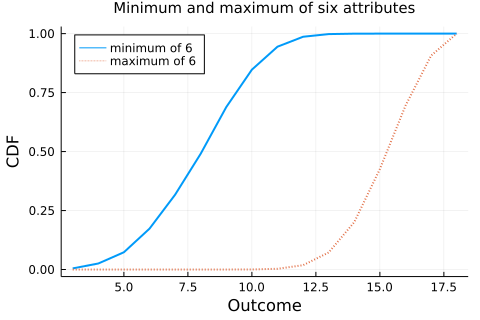

In [38]:
plot(cdf_min6, label="minimum of 6")
plot!(cdf_max6, label="maximum of 6", style=:dot, legend=:topleft)
decorate_dice!("Minimum and maximum of six attributes")
ylabel!("CDF")

In [39]:
cdf_min_dist6 = mindist(cdf_best3, 6);

In [40]:
isapprox(cdf_min_dist6, cdf_min6)

true

## Mixture

In [41]:
d4 = make_die(4)
d6 = make_die(6);

In [42]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

In [43]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

In [44]:
mix1 = (d4 .+ d6) ./ 2;

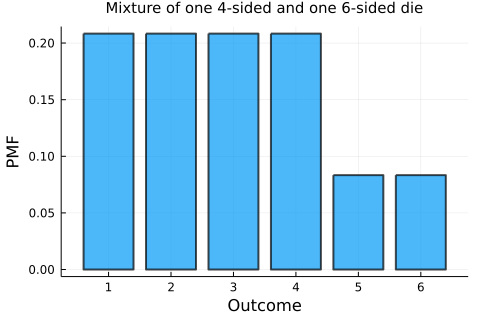

In [45]:
bar(mix1, alpha=0.7)
decorate_dice!("Mixture of one 4-sided and one 6-sided die")

In [46]:
mix2 = (d4 .+ 2 .* d6) ./ 3;

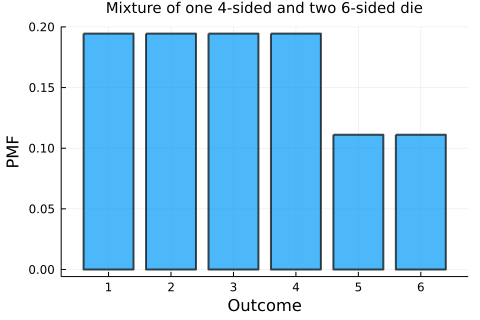

In [47]:
bar(mix2, alpha=0.7)
decorate_dice!("Mixture of one 4-sided and two 6-sided die")

In [48]:
total_damage = adddist(mix1, mix2);

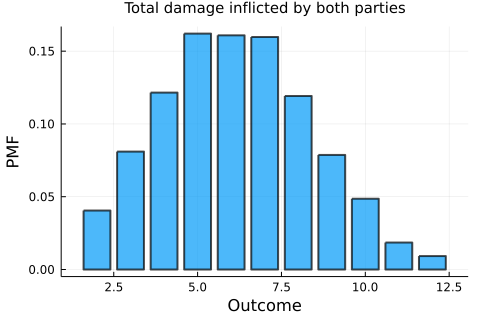

In [49]:
bar(total_damage,alpha=0.7)
decorate_dice!("Total damage inflicted by both parties")

## General Mixtures

In [50]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
normalize!(pmf_dice)
pmf_dice

┌───┬──────────┐
│   │    probs │
├───┼──────────┤
│ 4 │ 0.166667 │
│ 6 │ 0.333333 │
│ 8 │      0.5 │
└───┴──────────┘


In [51]:
dice = [make_die(sides) for sides in hypos];

In [52]:
make_dataframe(dice)

,1,2,3,4,5,6,7,8
,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?
1,0.25,0.25,0.25,0.25,missing,missing,missing,missing
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,missing,missing
3,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


In [53]:
coalesce.(make_dataframe(dice), 0)

,1,2,3,4,5,6,7,8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.0
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0
3,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


In [54]:
# This horror is from https://github.com/JuliaData/DataFrames.jl/issues/2065#issuecomment-568937464
transp(x) = DataFrame(collect.(eachrow(x)), Symbol.(axes(x,1)))

# alternatively, we could have used DataFrames' permutedims(). However, that would have required adding
# an index column to the dataframe.

df = transp(coalesce.(make_dataframe(dice), 0));

In [55]:
df

,1,2,3
,Float64,Float64,Float64
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.0,0.166667,0.125
6,0.0,0.166667,0.125
7,0.0,0.0,0.125
8,0.0,0.0,0.125


In [56]:
df = DataFrame(eachcol(df) .* pmf_dice.ps, :auto);
df

,x1,x2,x3
,Float64,Float64,Float64
1,0.0416667,0.0555556,0.0625
2,0.0416667,0.0555556,0.0625
3,0.0416667,0.0555556,0.0625
4,0.0416667,0.0555556,0.0625
5,0.0,0.0555556,0.0625
6,0.0,0.0555556,0.0625
7,0.0,0.0,0.0625
8,0.0,0.0,0.0625


In [57]:
select(df, AsTable(:) => ByRow(sum) => :sum)

,sum
,Float64
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.0625
8,0.0625


In [58]:
"""Make a mixture of distributions."""
function make_mixture(pmf, pmf_seq)
    transpose(df) = DataFrame(collect.(eachrow(df)), :auto)
    df = transpose(coalesce.(make_dataframe(pmf_seq), 0))
    df = DataFrame(eachcol(df) .* pmf.ps, :auto)
    total = select(df, AsTable(:) => ByRow(sum) => :sum)
    return total
end

make_mixture

In [59]:
mix = make_mixture(pmf_dice, dice);

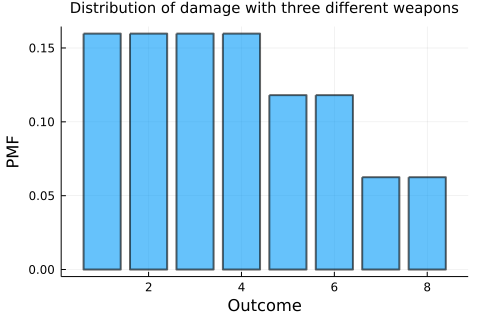

In [60]:
# use StatsPlots to plot a DataFrame
using StatsPlots
@df mix bar(:sum, label="mixture", alpha=0.6)
decorate_dice!("Distribution of damage with three different weapons")

# alternatively, we could have used makemixture() which returns a Pmf

## Summary

## Exercises

In [61]:
# 7.1
standard = [15,14,13,12,10,8]
cdf_standard = cdffromseq(standard);

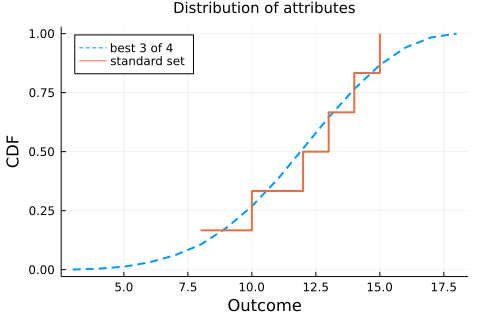

In [62]:
plot(cdf_best3, label="best 3 of 4", style=:dash)
plot!(cdf_standard, label="standard set", legend=:topleft, seriestype = :steppost)

decorate_dice!("Distribution of attributes")
ylabel!("CDF")

In [63]:
(mean(cdf_best3), mean(cdf_standard))

(12.238399999999999, 12.0)

In [64]:
(std(cdf_best3), std(cdf_standard))

(2.87439827442197, 2.3804761428476167)

In [65]:
lt_dist(cdf_best3, 8)

0.061599999999999995

In [66]:
gt_dist(cdf_best3, 15)

0.13259999999999994

In [67]:
(lt_dist(cdf_min6, 8), 1 .- (1 .- lt_dist(cdf_best3, 8)) .^ 6)

(0.317145784753615, 0.317145784753615)

In [68]:
(gt_dist(cdf_max6, 15), 1 .- (1 .- gt_dist(cdf_best3, 15)) .^ 6)

(0.5740913044950327, 0.5740913044950327)

In [69]:
# 7.2
hypos = [6, 8, 10]
prior = Pmf(1, hypos)
likelihood = 1 ./ prior.qs
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌────┬──────────┐
│    │    probs │
├────┼──────────┤
│  6 │ 0.425532 │
│  8 │ 0.319149 │
│ 10 │ 0.255319 │
└────┴──────────┘


In [70]:
d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

dice = d6, d8, d10;

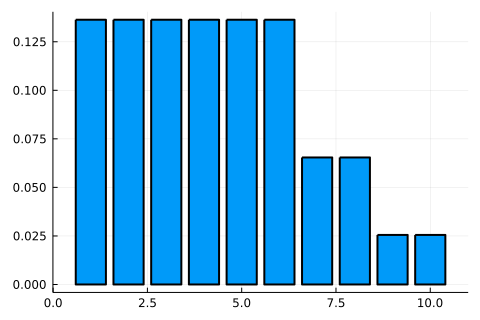

In [71]:
mix3 = make_mixture(posterior, dice)
@df mix3 bar(:sum)

In [72]:
mix3[6,:sum]

0.13634751773049647

In [73]:
# 7.3
μ = 950
σ = 50

sample = rand(Normal(μ, σ), 365);

In [74]:
cdf = cdffromseq(sample)

for n in 2:6
    cdf_max = maxdist(cdf, n)
    println("$n  $(mean(cdf_max))")
end

2  979.7662999448063
3  993.2702862898852
4  1001.9720671988268
5  1008.2735101694778
6  1013.1511790477986


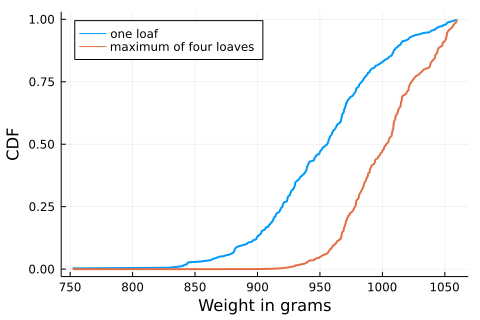

In [75]:
plot(cdf, label="one loaf")
plot!(maxdist(cdf,4), label="maximum of four loaves", legend=:topleft)
xlabel!("Weight in grams")
ylabel!("CDF")